<a href="https://colab.research.google.com/github/erodola/DLAI-s2-2023/blob/main/labs/08/8_Variational_Autoencoders_(VAEs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning & Applied AI

We recommend going through the notebook using Google Colaboratory.

# Tutorial 8: Variational Autoencoders (VAEs)


In this tutorial, we will cover:

- Reparameterization trick
- Variational Autoencoders (VAEs)
- Latent spaces

Based on original material by Dr. Luca Moschella, Dr. Antonio Norelli and Dr. Marco Fumero.

Course:

- Website and notebooks will be available at https://github.com/erodola/DLAI-s2-2024/

##Import dependencies (run the following cells)

In [4]:
# @title import dependencies

from typing import Mapping, Union, Optional, Tuple
from pathlib import Path

import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms

import os
import pickle
from tqdm.notebook import tqdm

from __future__ import print_function, division


In [5]:
# @title reproducibility stuff

import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False

## Brush-up of Information Theory

Many ML and DL methods are based on a variety of concepts from probability theory and information theory.

Since Variational AutoEncoders are very intensive on this aspect, it can be useful to brush up some fundamentals.

If you are not already confident with the concepts of marginal probability, Shannon entropy, cross-entropy, Kullback–Leibler divergence and mutual information, we suggest a quick read: this [blog post](http://colah.github.io/posts/2015-09-Visual-Information/) with awesome visualizations by Chris Olah; and a book reference, [*Information Theory, Inference, and Learning Algorithms*](https://www.inference.org.uk/itprnn/book.pdf) by David J.C. MacKay.


## Variational Autoencoders (VAEs)

You may have already encountered autoencoders in the context of signal processing or information theory as compression systems.
The task of data compression is a good starting point to understand neural autoencoders.

In the context of deep learning, autoencoders (AEs) are neural networks designed so that the output aims to replicate the input, featuring a **bottleneck** in the architecture to enforce this specific behavior.

The **encoder** portion of the AE compresses the input into a **latent code**, which captures essential information needed to _distinguish_ different inputs. Following this, the **decoder** part takes the latent code and attempts to _reconstruct_ the original input, focusing on the information necessary for reconstruction rather than differentiation.

The loss of a standard AE is simply a **reconstruction loss**; in the case of an image it may be a simple per-pixel comparison.

You can imagine how delicate is the balance⚖️ between these two components! How can we ensure that encoder and decoder do their respective jobs?

From a very pragmatic point of view, VAEs extend this concept by introducing noise into the latent code. The noise level is a trainable parameter, and the loss function includes an additional term that encourages higher noise levels, counteracting the reconstruction loss that would otherwise minimize noise. This approach of using VAEs to introduce regularization into standard AEs provides a deeper insight into their probabilistic underpinnings.

### [Auto-encoding Variational Bayes](https://arxiv.org/abs/1312.6114)

Let's start with a new interpretation: the inputs, hidden representations, and reconstructed outputs of a VAE are probabilistic **random variables** within a directed graphical model.

In a Bayesian perspective:
- The encoder's job is to take observed input data (like images, text, etc.) and map it to a probability distribution of latent (hidden) attributes. Each attribute corresponds to a dimension in the latent space; they are not directly observed, but are inferred from the input.
- **The latent code is sampled from this distribution**.
- The decoder takes the latent codes (the sampled attributes) and tries to reconstruct the input data or generate new data samples that are similar to the observed inputs.

In this view, the training dataset is just the tip of an iceberg; the observed result of an **underlying causative probabilistic process**.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/vae1.png)

_Note: in the illustration above, $p_\theta(x|z)$ should also output a distribution; the figure assumes this distribution was sampled to produce $\tilde{x}$._

The power of the resulting model is captured by Feynman's famous [chalkboard quote](http://archives-dc.library.caltech.edu/islandora/object/ct1:483): “What I cannot create, I do not understand.”

The following gif shows the decoded samples of a continuous path over the latent space of a VAE trained on MNIST.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/interp.gif)

Rather than directly outputting values for the latent state as we would in a standard AE, the encoder model of a VAE outputs entire probability distributions. During training we sample from these distributions to obtain a latent code for the decoder.

Traditional **VAEs make the strong assumption on the distribution of latent codes as a multivariate Gaussian with a diagonal covariance structure**, so each component is normally distributed and indipendent from the others.

A $n$-dimensional Gaussian is defined by a vector $(\mu_1, ... , \mu_n)$ and a covariance matrix $\Sigma \in \mathbb{R}^{n \times n}$. Since we are assuming independent components, $\Sigma$ is a diagonal matrix and we can describe it with a single vector of size $n$ storing the diagonal. By this symmetry, the shape of the Gaussian will be spherical (in the general case of arbitrary covariance matrices, it will be ellipsoidal).

In practice, this means that the Encoder of a VAE outputs two vectors collecting the **means** and the **variances** (instead of encoding the variance $\sigma^2$ we will work for convenience with the logarithm of the variance $\log(\sigma^2)$).

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/implementation.png)

Consider the implications of the assumption that a VAE trained on the MNIST dataset maps the entire dataset to a **unimodal** distribution in the latent space. One might question if this truly reflects the underlying causative probabilistic process. For instance, wouldn't a ten-modal distribution, representing each digit separately, be more logical?

The answer largely depends on how you plan to use these representations. For generative model applications like creating new data samples, a unimodal Gaussian distribution is practical. It allows for smooth interpolations between different digits, which is harder to achieve with a multimodal distribution. This feature is particularly appealing when generating new images that blend characteristics of various digits.

However, if the goal is to achieve a more accurate representation of the world, as in reinforcement learning, this assumption may not be as satisfying. It raises the question: what does it mean to interpolate between fundamentally different concepts, such as the numbers 3 and 5? The suitability of a unimodal versus a multimodal distribution in the latent space truly hinges on the specific objectives and the desired outcomes of using VAEs.

### Intuition: encoding probability distributions (from Jeremy Jordan's [blog post](https://www.jeremyjordan.me/variational-autoencoders/))



Let's suppose we've trained an autoencoder model on a large dataset of faces with a encoding dimension of 6. An ideal autoencoder will learn descriptive attributes of faces such as skin color, whether or not the person is wearing glasses, etc. It's the autoencoder's attempt to describe an observation in a compressed representation.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/int1.png)

In the example above, we've described the input image in terms of its latent attributes using a **single value to describe each attribute**.

However, we may prefer to represent each latent attribute as a range of possible values. For instance, what *single value* would you assign for the smile attribute if you feed in a photo of the Mona Lisa? Using a variational autoencoder, we can describe latent attributes in probabilistic terms.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/int2.png)


With this approach, we represent each latent attribute for a given input as a probability distribution. When decoding from the latent state, we randomly sample from each distribution to generate a vector, that will be fed as input for our decoder model.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/int3.png)

By constructing our encoder model to output a range of possible values (a statistical distribution) from which we'll randomly sample to feed into our decoder model, we're essentially enforcing a continuous, smooth latent space representation. For any sampling of the latent distributions, we're expecting our decoder model to be able to accurately reconstruct the input. Thus, values which are nearby to one another in latent space should correspond with very similar reconstructions.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/int4.png)

### Implementation overview

We are now ready to do some coding!

Wait, have you noticed the elephant in the room? VAEs require to sample (_at training time!_) from the distribution predicted by the encoder, in order to obtain a latent code for the decoder. But how can we backpropagate gradients through a fundamentally random operation such as sampling?



#### Reparameterization trick

There's a clever technique that lets us perform backpropagation through a stochastic node in the computational graph, meaning a node where the output is randomly determined.

Let's build a toy model comprising a random sampling step.

In [6]:
# Some data
data = torch.rand(10)

# Some parameters to train
deterministic_transform1 = torch.nn.Linear(in_features=10,  out_features=10)
deterministic_transform2 = torch.nn.Linear(in_features=10,  out_features=10)

# My expected output
gold_output = torch.ones(10)

We want optimize the parameters in order to obtain `gold_output` from the following computation:

In [7]:
# My stochastic prediction
pred_mean = deterministic_transform1(data)
pred_std = torch.ones_like(data)

# Random sampling from **separate** normal distributions (each with its own mean and std), one per data point.
sampling = torch.normal(mean=pred_mean, std=pred_std)

pred_output = deterministic_transform2(sampling)

# Error function
loss = F.mse_loss(pred_output, gold_output)
deterministic_transform1.zero_grad()
loss.backward()

# then optimize with some optimizer

But...

In [8]:
deterministic_transform1.weight.grad

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

We have a problem, this doesn't work! Those zeros do not mean at all that we are at a minimum -- in fact, the prediction is far from perfect:


In [9]:
loss

tensor(2.0999, grad_fn=<MseLossBackward0>)

The specific problem here is that we can’t backpropagate through the `normal` function that we used for random sampling.

This is because it doesn’t make much sense to differentiate with respect to a stochastic node; the gradient would technically be a random variable too!

So let’s... reparametrize! The idea is to restructure the random sampling process so that the **randomness is isolated from the parameters being optimized**.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/trick.png)

Instead of sampling directly from a distribution $q(z|\phi,x)$ that depends on the parameters $\phi$ (left plot), which would be a non-differentiable operation, here's what you do:
- First, sample from a fixed distribution $p(\varepsilon)$ (like a standard normal distribution) which does not depend on the network parameters;
- Then, apply a differentiable transformation $g(\phi,x,\varepsilon)$ to this sample, where the transformation involves the parameters of interest.

In [10]:
# My stochastic prediction
pred_mean = deterministic_transform1(data)
pred_std = torch.ones_like(data)

# Reparametrization trick:

rand_source = torch.randn(10)  # sampling from canonical gaussians, one per data point

This sampling operation is detached from the computational graph!

In [11]:
rand_source.requires_grad

False

Now transform the canonical samples as if they were drawn from our parametrized distributions:

In [12]:
sampling = rand_source * pred_std + pred_mean

pred_output = deterministic_transform2(sampling)

# My error
loss = F.mse_loss(pred_output, gold_output)
deterministic_transform1.zero_grad()
loss.backward()

# then optimize with some optimizer

Note that the randomness of the sampling comes from the random sampling of `rand_source`. There is no randomness in the computational graph itself. Once `rand_source` is chosen, it is fixed.

In [13]:
deterministic_transform1.weight.grad

tensor([[-0.0943, -0.0978, -0.0409, -0.1025, -0.0417, -0.0642, -0.0274, -0.0848,
         -0.1005, -0.0142],
        [ 0.0186,  0.0193,  0.0081,  0.0202,  0.0082,  0.0127,  0.0054,  0.0167,
          0.0198,  0.0028],
        [-0.0424, -0.0440, -0.0184, -0.0461, -0.0188, -0.0289, -0.0123, -0.0381,
         -0.0452, -0.0064],
        [ 0.1200,  0.1245,  0.0521,  0.1305,  0.0531,  0.0817,  0.0349,  0.1080,
          0.1280,  0.0181],
        [ 0.0805,  0.0835,  0.0349,  0.0876,  0.0356,  0.0548,  0.0234,  0.0724,
          0.0859,  0.0122],
        [ 0.0271,  0.0281,  0.0118,  0.0295,  0.0120,  0.0185,  0.0079,  0.0244,
          0.0289,  0.0041],
        [ 0.1264,  0.1311,  0.0549,  0.1375,  0.0559,  0.0861,  0.0368,  0.1137,
          0.1348,  0.0191],
        [ 0.0354,  0.0367,  0.0154,  0.0385,  0.0157,  0.0241,  0.0103,  0.0319,
          0.0378,  0.0053],
        [-0.2037, -0.2112, -0.0884, -0.2215, -0.0901, -0.1387, -0.0592, -0.1832,
         -0.2172, -0.0307],
        [ 0.1660,  

That's it, now we can adjust the parameters of the distribution through backpropagation, to improve our stochastic prediction!

**We constructed the parametrized random variable via a parametrized deterministic function of a parameter-free random variable.**



Another way of thinking about it is that we have moved the source of noise outside of the main flow of the network and used the noise as a way to sample from the expectation.


🚀 That said, PyTorch has ready-to-use parametrizable probability distributions and sampling functions 🚀

In [14]:
data = torch.rand(10)
pred_mean = deterministic_transform1(data)
pred_std = torch.ones_like(data)

normal_distribution = torch.distributions.Normal(loc=pred_mean, scale=pred_std)
sampling = normal_distribution.rsample()  # rsample allows pathwise derivatives, i.e. implements the reparametrization trick

pred_output = deterministic_transform2(sampling)

# My error
loss = F.mse_loss(pred_output, gold_output)
deterministic_transform1.zero_grad()
loss.backward()

deterministic_transform1.weight.grad

tensor([[-2.7254e-02, -1.3411e-04, -2.9849e-02, -3.2196e-02, -3.5833e-02,
         -1.4072e-02, -3.2847e-03, -2.2557e-02, -2.8590e-02, -8.6396e-05],
        [ 1.1770e-01,  5.7917e-04,  1.2891e-01,  1.3904e-01,  1.5475e-01,
          6.0773e-02,  1.4185e-02,  9.7415e-02,  1.2347e-01,  3.7311e-04],
        [-1.2134e-01, -5.9706e-04, -1.3289e-01, -1.4334e-01, -1.5953e-01,
         -6.2650e-02, -1.4624e-02, -1.0042e-01, -1.2728e-01, -3.8463e-04],
        [ 1.9566e-01,  9.6277e-04,  2.1429e-01,  2.3113e-01,  2.5724e-01,
          1.0102e-01,  2.3581e-02,  1.6193e-01,  2.0525e-01,  6.2023e-04],
        [ 2.9186e-03,  1.4362e-05,  3.1965e-03,  3.4478e-03,  3.8373e-03,
          1.5070e-03,  3.5175e-04,  2.4156e-03,  3.0617e-03,  9.2520e-06],
        [ 1.1149e-01,  5.4863e-04,  1.2211e-01,  1.3171e-01,  1.4659e-01,
          5.7568e-02,  1.3437e-02,  9.2278e-02,  1.1696e-01,  3.5343e-04],
        [ 3.4047e-02,  1.6754e-04,  3.7289e-02,  4.0220e-02,  4.4764e-02,
          1.7580e-02,  4.1034e-0

Note how PyTorch uses the terms "location" (`loc`) and "scale" (`scale`) as they are more general and apply to a wider variety of distributions, not just those where you think of the parameters explicitly as mean and standard deviation. They describe how the distribution is positioned (location) and how spread out it is (scale), regardless of the exact nature of the distribution.

- Check out the [`torch.distributions`](https://pytorch.org/docs/stable/distributions.html) package to learn more.
- Check out [this](https://bochang.me/blog/posts/pytorch-distributions/) and [especially this](https://ericmjl.github.io/blog/2019/5/29/reasoning-about-shapes-and-probability-distributions/) to know about `batch_shape`, `sample_shape` and `event_shape` in the distributions package.

For a more formal explanation of the reparametrization trick check out this [post](https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important).

## Implementing a VAE

At last!

In [15]:
# 2-d latent space, parameter count in the same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)

latent_dims = 2       # size of the bottleneck
num_epochs = 40
batch_size = 128
capacity = 64         # output channels for the first convolutional layer
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

### Data Loading

We'll use again the MNIST dataset, comprising digits in the 0-9 range as 28x28 grayscale images. We do not center them at 0, because we will be using binary cross-entropy for the reconstruction loss, that treats pixel values as probabilities $p \in [0,1]$

In [16]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=max(10000, batch_size), shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 154101118.42it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 107771969.59it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47763989.95it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6798903.91it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw




#### **Encoder and Decoder**
We'll use a convolutional encoder and decoder, which generally gives better performance than fully-connected versions with the same number of parameters.

**Bottleneck**

In the convolutional layers, we increase the number of channels as we approach the bottleneck. However, the total number of features still decreases: the channels increase by a factor of 2 at each convolution, but the spatial size decreases by a factor of 4.


**Deconvolution**

In the decoder we are using a "transposed convolution" (`ConvTranspose2d` in PyTorch), also known as deconvolution. You can think of it as an attempt to recover a high-resolution feature map from one with lower resolution.

*Blue cells are inputs, and cyan cells are outputs* (go [here](https://github.com/vdumoulin/conv_arithmetic) for more examples)

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/deconv.gif)

Despite its name, it's **not the mathematical inverse of convolution**. Instead, it involves a process that can be thought of as "spreading out" the input values over a larger spatial area. It operates by padding the input (adding zeros around and possibly _between_ input values) and then applying a conventional convolution operation. The effect is that each input value influences multiple output values, and by learning the appropriate filter weights, the network can effectively learn to increase the spatial resolution of the input data.

The "transposed" part comes from the idea of using the transpose of the convolution operator, since taking the transpose would reverse the dimensionality of input and output. However, in practice this operation is not performed by constructing the convolution matrix and taking its transpose.


**Kernel size**

We are using `kernel_size=4` and `stride=2`. The motivation behind this choice is to lessen the checkerboard artifacts described [here](https://distill.pub/2016/deconv-checkerboard). TLDR: use a kernel size that is divided by the stride.

In [17]:
class Encoder(nn.Module):
    def __init__(self, hidden_channels: int, latent_dim: int) -> None:
        """
        Simple encoder module

        It predicts the `mean` and `log(variance)` parameters.

        The choice to use the `log(variance)` is explained below.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=hidden_channels,
                               kernel_size=4,
                               stride=2,
                               padding=1) # out: hidden_channels x 14 x 14

        self.conv2 = nn.Conv2d(in_channels=hidden_channels,
                               out_channels=hidden_channels*2,
                               kernel_size=4,
                               stride=2,
                               padding=1) # out: (hidden_channels x 2) x 7 x 7

        self.fc_mu = nn.Linear(in_features=hidden_channels*2*7*7,
                               out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=hidden_channels*2*7*7,
                                   out_features=latent_dim)

        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :param x: batch of images with shape [batch, channels, w, h]
        :returns: the predicted mean and log(variance)
        """
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))

        x = x.view(x.shape[0], -1)

        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)

        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, hidden_channels: int, latent_dim: int) -> None:
        """
        Simple decoder module
        """
        super().__init__()
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(in_features=latent_dim,
                            out_features=hidden_channels*2*7*7)

        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_channels*2,
                                        out_channels=hidden_channels,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_channels,
                                        out_channels=1,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)

        self.activation = nn.ReLU()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param x: a sample from the distribution governed by the mean and log(var)
        :returns: a reconstructed image with size [batch, 1, w, h]
        """
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_channels*2, 7, 7)
        x = self.activation(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x


#### Why the log-var?

Outputting the log-variance $\log(\sigma^2)$ instead of $\sigma^2$ directly in the encoder is a common practice for several reasons:

1. **_Avoiding negative vatiance:_** Directly predicting $\sigma^2$ can risk the model outputting negative numbers, which are not valid. By predicting $\log(\sigma^2)$, the model can output values in $(-\infty,+\infty)$, which can then be exponentiated to ensure the variance is always positive.

2. **_Preventing underflow:_** Very small variances (close to zero) can lead to numerical underflow. Operating in log space helps avoid this issue, as it can represent very small numbers without underflow.

3. **_Gradient stability:_** Gradients of variance can vary widely, leading to unstable training. When working with $\log(\sigma^2)$, the gradients tend to be more stable, making the optimization potentially faster.

4. **_Smoother loss landscape:_** The transformation to log space tends to "stretch" smaller values and "compress" larger ones, which can lead to a smoother optimization landscape, which in turn is easier to navigate toward the minimum.

4. **_KL divergence:_** You need the log-variance in the regularization term anyways.

Of course, to perform the actual sampling you must transform the log-variance back to the original space; this is done by computing:

$$ z=\mu + \exp(\frac{\log(\sigma^2)}{2}) \cdot \epsilon $$

where $\epsilon$ is drawn from a standard normal distribution.

#### **VAE**

The VAE definition is straghforward since we have all the pieces we need:
- The Encoder
- The reparametrization trick
- The Decoder




In [18]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, hidden_channels: int, latent_dim: int):
        super().__init__()
        self.encoder = Encoder(hidden_channels=hidden_channels,
                               latent_dim=latent_dim)
        self.decoder = Decoder(hidden_channels=hidden_channels,
                               latent_dim=latent_dim)

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):

        if self.training:
            # Convert the logvar to std
            std = (logvar * 0.5).exp()

            # the reparameterization trick
            return torch.distributions.Normal(loc=mu, scale=std).rsample()

            # Or if you prefer to do it without a torch.distribution...
            # std = logvar.mul(0.5).exp_()
            # eps = torch.empty_like(std).normal_()
            # return eps.mul(std).add_(mu)
        else:
            return mu

vae = VariationalAutoencoder(hidden_channels=capacity, latent_dim=latent_dims)
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


#### Loss function



In [19]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # You can look at the derivation of the KL term, in the special case where p and q are
    # gaussians (i.e. this notebook) here: https://arxiv.org/abs/1907.08956
    # Starts at Eq.(29) and ends at Eq.(40).
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

### Training VAE


In [22]:
# @title training utilities

import pandas as pd
import numpy as np

from typing import Callable, Optional
def make_averager() -> Callable[[Optional[float]], float]:
    """ Returns a function that maintains a running average

    :returns: running average function
    """
    count = 0
    total = 0

    def averager(new_value: Optional[float]) -> float:
        """ Running averager

        :param new_value: number to add to the running average,
                          if None returns the current average
        :returns: the current average
        """
        nonlocal count, total
        if new_value is None:
            return total / count if count else float("nan")
        count += 1
        total += new_value
        return total / count

    return averager

def save_in_dataframe(df_log, labels, mus, stddevs, epoch):
    df = pd.DataFrame()

    df['index'] = np.arange(len(mus[:,0])) * epoch
    df['image_ind'] = np.arange(len(mus[:,0]))
    df['class'] = labels.data.numpy().astype(str)
    df['mu_x'] = mus[:,0]
    df['mu_y'] = mus[:,1]
    df['std_x'] = stddevs[:,0]
    df['std_y'] = stddevs[:,1]
    df['epoch'] = np.ones(len(mus[:,0])) * epoch

    df_log = pd.concat([df_log, df])

    return df_log

def run_on_testbatch(df_log, vae, epoch, x, y):
    with torch.no_grad():
        x = x.to(device)
        x, mus, stddevs = vae(x)
        x = x.to('cpu')
        mus = mus.to('cpu').data.numpy()
        stddevs = stddevs.to('cpu').mul(0.5).exp_().data.numpy()

    return save_in_dataframe(df_log, y, mus, stddevs, epoch)

def refresh_bar(bar, desc):
    bar.set_description(desc)
    bar.refresh()

In [18]:
# 🚥 10 minutes on GPU with default parameters 🚥

# --- in a few cells you can download some pre-trained weights ---

vae = VariationalAutoencoder(hidden_channels=capacity, latent_dim=latent_dims)
vae = vae.to(device)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

df_log = pd.DataFrame()
test_batch_x, test_batch_y = next(iter(test_dataloader))
df_log = run_on_testbatch(df_log, vae, 0, test_batch_x, test_batch_y )

train_loss_avg = []

print('Training ...')

tqdm_bar = tqdm(range(1, num_epochs+1), desc="epoch [loss: ...]")
for epoch in tqdm_bar:
    train_loss_averager = make_averager()

    batch_bar =  tqdm(train_dataloader, leave=False, desc='batch', total=len(train_dataloader))
    for image_batch, _ in batch_bar:

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # vae loss computation
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer
        optimizer.step()

        refresh_bar(batch_bar, f"train batch [loss: {train_loss_averager(loss.item()):.3f}]")

    refresh_bar(tqdm_bar, f"epoch [loss: {train_loss_averager(None):.3f}]")

    train_loss_avg.append(train_loss_averager(None))
    df_log = run_on_testbatch(df_log, vae, epoch, test_batch_x, test_batch_y )

df_log = df_log.set_index(['index'])

plt.figure(figsize=(6, 3))
plt.plot(train_loss_avg)
plt.show()

Training ...


epoch [loss: ...]:   0%|          | 0/40 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

batch:   0%|          | 0/469 [00:00<?, ?it/s]

## Latent space (from Jeremy Jordan's [blog post](https://www.jeremyjordan.me/variational-autoencoders/))

Using VAEs we are able to learn **smooth latent state representations** of the input data. For standard AEs, we simply need to learn an encoding that allows us to reproduce the input.

As you can see in the left-most figure, focusing only on reconstruction loss allows us to separate out the classes (in this case, MNIST digits), but there's an uneven distribution of data within the latent space. In other words, there are areas in the latent space that don't represent anything from our observed data.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/latent.png)



On the flip side, if we only focus only on ensuring that the latent distribution is similar to the prior (through our KL divergence loss term), we end up describing every observation as a realization of the same standard Gaussian; in other words, we've failed to describe the original data.

**However, when the two terms are optimized simultaneously, the latent codes are encouraged to stay close to the prior distribution, but deviate whenever necessary to describe salient features of the input.**

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/distr.png)


In the following cells you can visualize how the training modified the latent space of our network.




In [25]:
# @title Trained VAE

import plotly.express as px

n_samples = 1470 #@param {type:"slider", min:10, max:5000, step:10}
size_exactly_as_std = False #@param {type:"boolean"}

def plot_latent_params(df, max_size: bool):
    if size_exactly_as_std:
        size_max = 200
    else:
        size_max=None

    return px.scatter(
        df.loc[df['image_ind'] < n_samples],
        x="mu_x", y="mu_y",
        animation_frame="epoch", animation_group="image_ind",
        size="std_x",
        color="class",
        hover_name="image_ind", #facet_col="class",
        color_discrete_sequence=px.colors.qualitative.Plotly,
        width=800,
        height=800,
        size_max=size_max,
        range_x=[-5, 5],
        range_y=[-5, 5])

plot_latent_params(df_log, max_size = size_exactly_as_std)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
# @title Untrained VAE

import plotly.express as px

n_samples = 1470 #@param {type:"slider", min:10, max:5000, step:10}
size_exactly_as_std = False #@param {type:"boolean"}

vae_zero = VariationalAutoencoder(hidden_channels=capacity, latent_dim=latent_dims)
vae_zero = vae_zero.to(device)

df_log3 = pd.DataFrame()
df_log3 = run_on_testbatch(df_log3, vae_zero, 0, test_batch_x, test_batch_y )


plot_latent_params(df_log3, max_size = size_exactly_as_std)

### Feeling lazy?

You can download the pretrained models without having to wait for ~100 training epochs.

In [20]:
if False:
    filename = 'vae_2d.pth'
    import urllib
    if not os.path.isdir('./pretrained'):
        os.makedirs('./pretrained')
    print('downloading ...')
    filepath = Path("./pretrained") / filename
    urllib.request.urlretrieve(f"https://github.com/erodola/DLAI-s2-2024/raw/main/labs/{filename}",
                                filepath)
    vae.load_state_dict(torch.load(filepath))
    vae = vae.to(device)
    print(f'done, loaded in {device}')

downloading ...
done, loaded in cuda:0


### Evaluate on the Test Set


In [23]:
# set to evaluation mode
vae.eval()

test_loss_averager = make_averager()

with torch.no_grad():

    test_bar = tqdm(test_dataloader, total=len(test_dataloader), desc = 'batch [loss: ...]')
    for image_batch, _ in test_bar:
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        refresh_bar(test_bar, f"test batch [loss: {test_loss_averager(loss.item()):.3f}]")


print(f'Average test loss: {test_loss_averager(None)})')


# Build a dictionary label2images for future use
from collections import defaultdict
label2img = defaultdict(list)
for img_batch, label_batch in test_dataloader:
    img_batch = img_batch.to(device)
    for i in range(img_batch.shape[0]):
        # maintain the singleton batch dimension with [i]
        label2img[label_batch[i].item()].append(img_batch[[i], ...])


batch [loss: ...]:   0%|          | 0/1 [00:00<?, ?it/s]

Average test loss: 1534288.875)


### Latent distributions and disentanglement

Keep in mind that the encoder of a VAE, when given an data point as input, outputs (the parameters of) a distribution _per dimension of the latent space_. If we inspect these distributions, we might see something like:

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/6-vae.png)


These latent distributions appear to be very tight -- a behavior that is closer to a deterministic AE rather than a VAE. To encourage the network to learn broader distributions, we may increase the weight $\beta>1$ of the KL divergence term.

This simple insight has led to the growth of a new class of models - **disentangled** variational autoencoders (see e.g. [beta-VAE](https://openreview.net/forum?id=Sy2fzU9gl)). As it turns out, by placing a larger emphasis on the KL divergence term we're also implicitly enforcing that the learned latent dimensions are uncorrelated (through our simplifying assumption of a diagonal covariance matrix). Essentially, each dimension is pushed to encode unique aspects of the data, leading to a more disentangled representation.

In disentangled representations, changes in one dimension of the latent space correspond to changes in one factor of variation in the data. This property is desirable for many applications, including interpretability and control over generated data.

$$
{\cal L}\left( {x,\hat x} \right) + \beta \sum\limits_j {KL\left( {{q_j}\left( {z|x} \right)||N\left( {0,1} \right)} \right)}
$$

Let's have a look at the latent distributions resulting from our trained model.

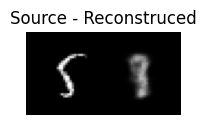

In [29]:
#@title Latent distributions { run: "auto" }

def reconstruct_images(images, model):
    model.eval()
    with torch.no_grad():
        images, _, _ = model(images.to(device))
        images = images.clamp(0, 1)
        return images



digit = 5 #@param {type:"slider", min:0, max:9, step:1}
digits_style = 10 #@param {type:"slider", min:0, max:42, step:1}

image = label2img[digit][digits_style]
bigimage = torch.cat((image,reconstruct_images(image, vae))).cpu()

mus, logvars = vae.encoder(image)
std = (logvars // 2 ).exp().squeeze().cpu()
mus = mus.squeeze().cpu()

plt.figure(figsize = (2, 17))
plt.imshow(torchvision.utils.make_grid(bigimage, 10, 5).permute(1, 2, 0))
plt.title("Source - Reconstruced")
plt.axis('off')
plt.show()


samples = 5000
bivariate_nd = torch.distributions.MultivariateNormal(loc=mus, covariance_matrix=std.diag())
bidist = bivariate_nd.sample((samples,))

fig = go.Figure()
fig.add_trace(go.Histogram2d(x=bidist[:, 0], y=bidist[:, 1],
                             xbins=dict(start=-5, end=5, size=0.1),
                             ybins=dict(start=-5, end=5, size=0.1),
                             histnorm='probability'))
fig.update_traces(opacity=0.6)
fig.update_layout(
    title="Distribution from which we sample for each image",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ),
    height=800,
    width=800,
    autosize=False,
)
fig.show()


samples = 5000
nd1 = torch.distributions.Normal(loc=mus[0], scale=std[0])
nd2 = torch.distributions.Normal(loc=mus[1], scale=std[1])

dist1 = nd1.sample((samples,))
dist2 = nd2.sample((samples,))

fig = go.Figure()
fig.add_trace(go.Histogram(x=dist1,
                           xbins=dict(start=-5, end=5, size=0.005),
                           histnorm='probability', name="0-th latent dim"))
fig.add_trace(go.Histogram(x=dist2,
                           xbins=dict(start=-5, end=5, size=0.005),
                           histnorm='probability',
                           name="1-th latent dim"))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.4)
fig.update_layout(
    title="Probability distributions of each latent dimension",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ),
    height=300
)
fig.show()


What do you think? Are these too tight?

### Visualize Reconstructions


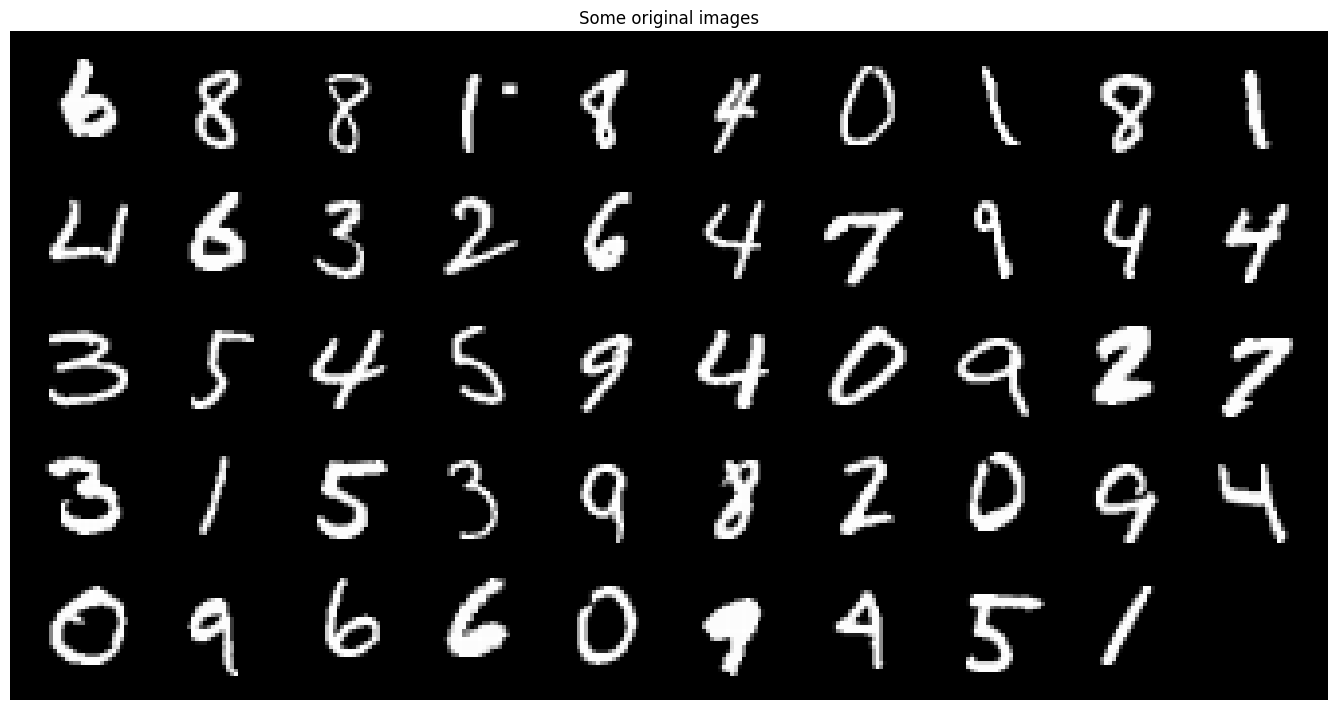

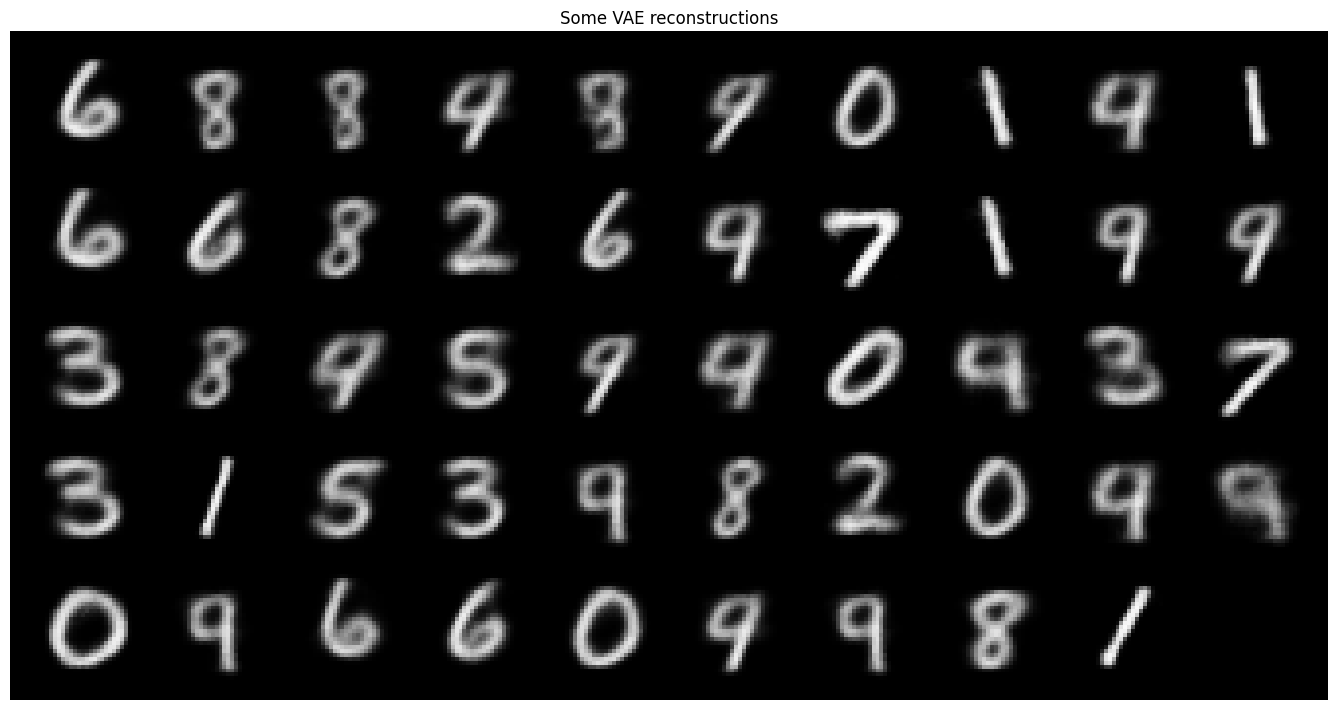

In [31]:
import torchvision.utils

images, labels = next(iter(test_dataloader))
reconstruced_images = reconstruct_images(images, vae).cpu()

# Matplolib plot, much faster for static images
# First visualize the original images
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(images[1:50],10,5).permute(1, 2, 0))
plt.title("Some original images")
plt.axis('off')
plt.show()

# Reconstruct and visualize the images using the vae
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(reconstruced_images[1:50], 10, 5).permute(1, 2, 0))
plt.title("Some VAE reconstructions")
plt.axis('off')
plt.show()

# # If you want to use plotly:
# # First visualize the original images
# px.imshow(torchvision.utils.make_grid(images[1:50],10,5).permute(1, 2, 0),
#           title="Some original images",
#           color_continuous_scale='grayscale',
#           color_continuous_midpoint=0.5).show()

# # Reconstruct and visualize the images using the vae
# px.imshow(torchvision.utils.make_grid(reconstruced_images[1:50], 10, 5).permute(1, 2, 0),
#           title="Some VAE reconstruction",
#           color_continuous_scale='grayscale',
#           color_continuous_midpoint=0.5).show()

### Interpolate in Latent Space


In [32]:
def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_2 + (1- lambda1) * latent_1

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.clamp(0, 1).cpu()

        return inter_image

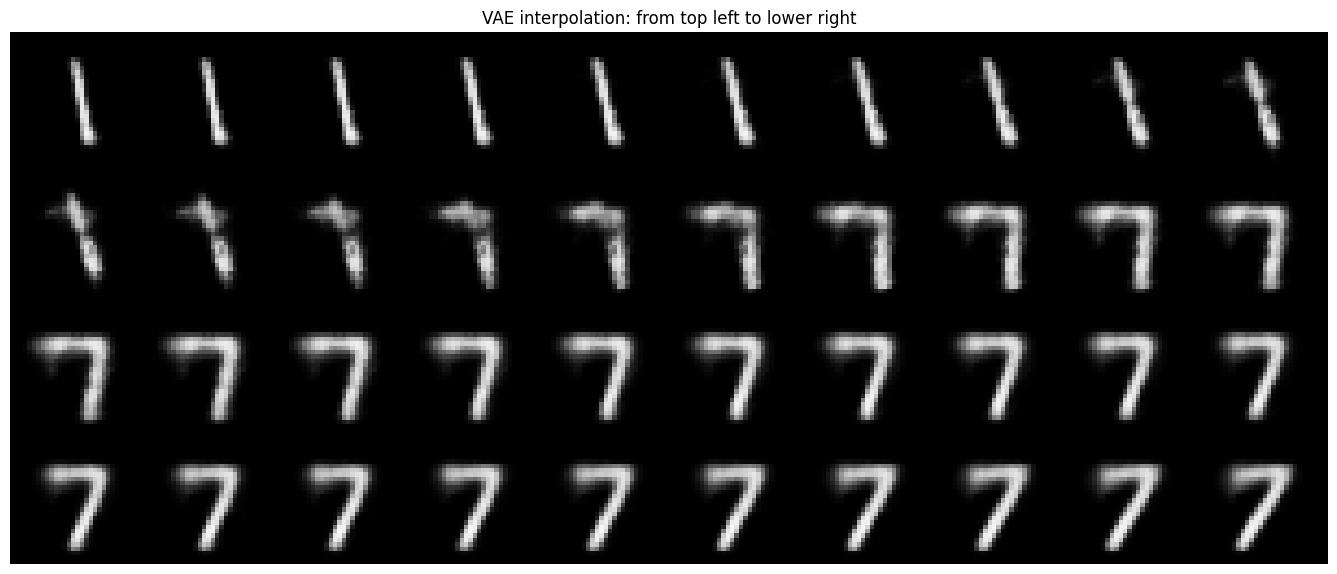

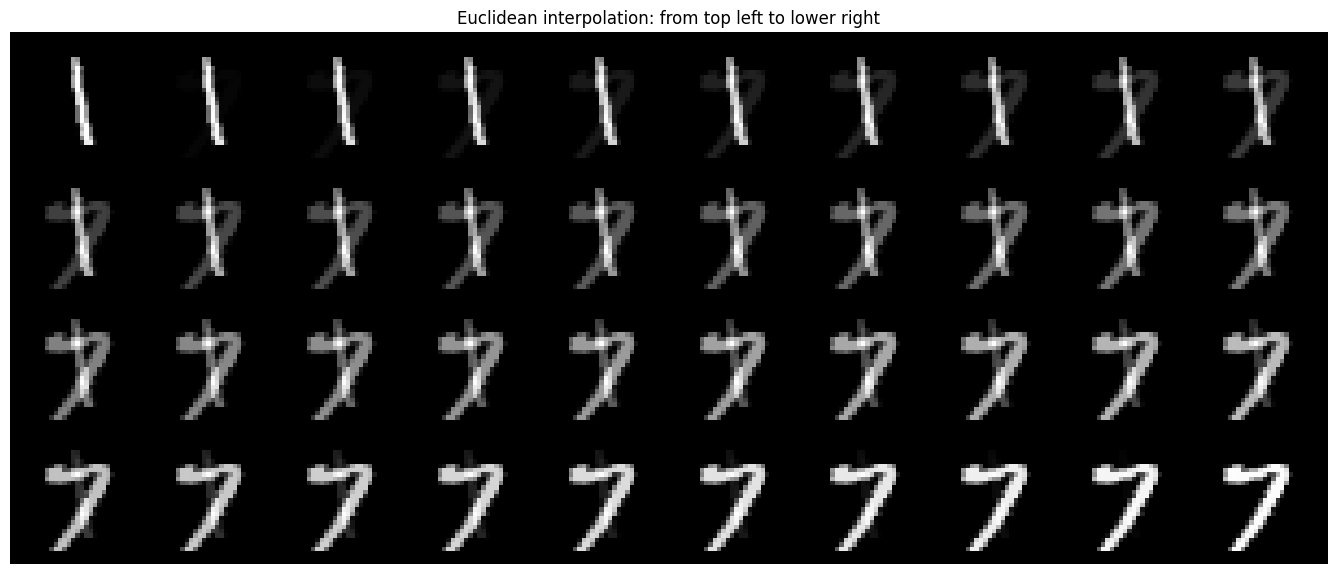

In [34]:
#@title Playground: Interpolation { run: "auto" }

def euclidean_interpolation(lambda1, img1, img2):

    with torch.no_grad():

        # explicit interpolation of the images
        inter_image = (1 - lambda1) * img1 + lambda1 * img2

        # reconstruct interpolated image
        inter_image = inter_image.clamp(0, 1).cpu()

        return inter_image

vae.eval()


num_interpolations = 40 #@param {type:"slider", min:10, max:100, step:10}

start_digit = 1 #@param {type:"slider", min:0, max:9, step:1}
end_digit = 7 #@param {type:"slider", min:0, max:9, step:1}
digits_style = 9 #@param {type:"slider", min:0, max:42, step:1}


start_image = label2img[start_digit][digits_style]
end_image = label2img[end_digit][digits_style]

# interpolation lambdas
lambda_range=np.linspace(0,1,num_interpolations)
bigimage = torch.cat([interpolation(x, vae, start_image, end_image) for x in lambda_range])
bigimage_euclidean = torch.cat([euclidean_interpolation(x, start_image, end_image) for x in lambda_range])



# Matplolib plot, much faster for static images
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(bigimage, 10).permute(1, 2, 0))
plt.title("VAE interpolation: from top left to lower right")
plt.axis('off')
plt.show()

# Matplolib plot, much faster for static images
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(bigimage_euclidean, 10).permute(1, 2, 0))
plt.title("Euclidean interpolation: from top left to lower right")
plt.axis('off')
plt.show()


# # To use plotly:
# px.imshow(torchvision.utils.make_grid(bigimage, 10).permute(1, 2, 0),
#           title="VAE interpolation: from top left to lower right",
#           color_continuous_scale='grayscale',
#           color_continuous_midpoint=0.5).show()

### VAE as a Generator

By sampling from the latent space, we can use the decoder network to form a generative model capable of creating new data similar to what was observed during training. Specifically, we'll sample from the prior distribution $p(z)$ which we assumed follows a unit Gaussian distribution.

Although the generated digits are not perfect, they are usually better than a deterministic AE.

In higher-dimensional latent spaces, the manifold of latent vectors that decode to valid digits is sparser. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction.

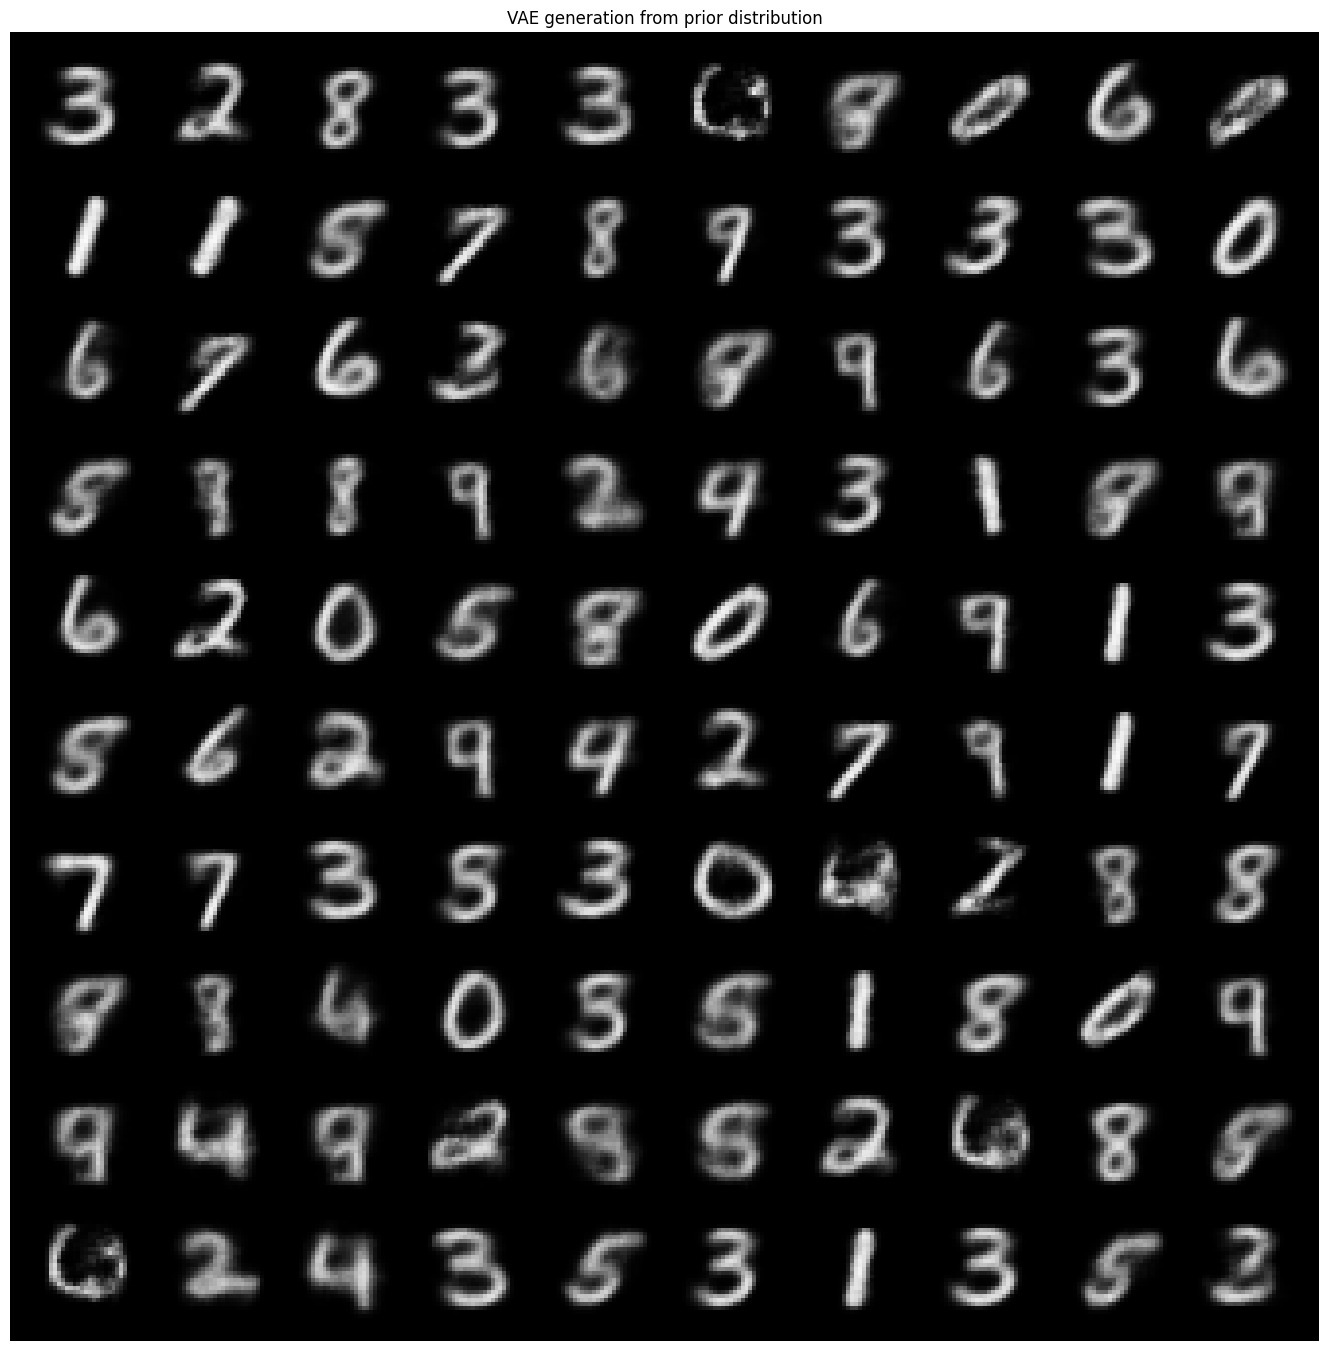

In [35]:
#@title Playground: Random generations { run: "auto" }

vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution, our prior distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu().clamp(0, 1)

    # Matplolib plot, much faster for static images
    plt.figure(figsize = (17, 17))
    plt.imshow(torchvision.utils.make_grid(img_recon.data[:100],10,5).permute(1, 2, 0))
    plt.title("VAE generation from prior distribution")
    plt.axis('off')
    plt.show()

    # # To use plotly:
    # px.imshow(torchvision.utils.make_grid(img_recon.data[:100],10,5).permute(1, 2, 0),
    #       title="VAE generation from prior distribution",
    #       color_continuous_scale='grayscale',
    #       color_continuous_midpoint=0.5,
    #       height=1000).show()

#### 2D Latent Space

The figure below visualizes the data generated by the decoder of a VAE trained on the MNIST handwritten digits dataset.

Here, we've linearly interpolated a grid of values and displayed the output of our decoder network.

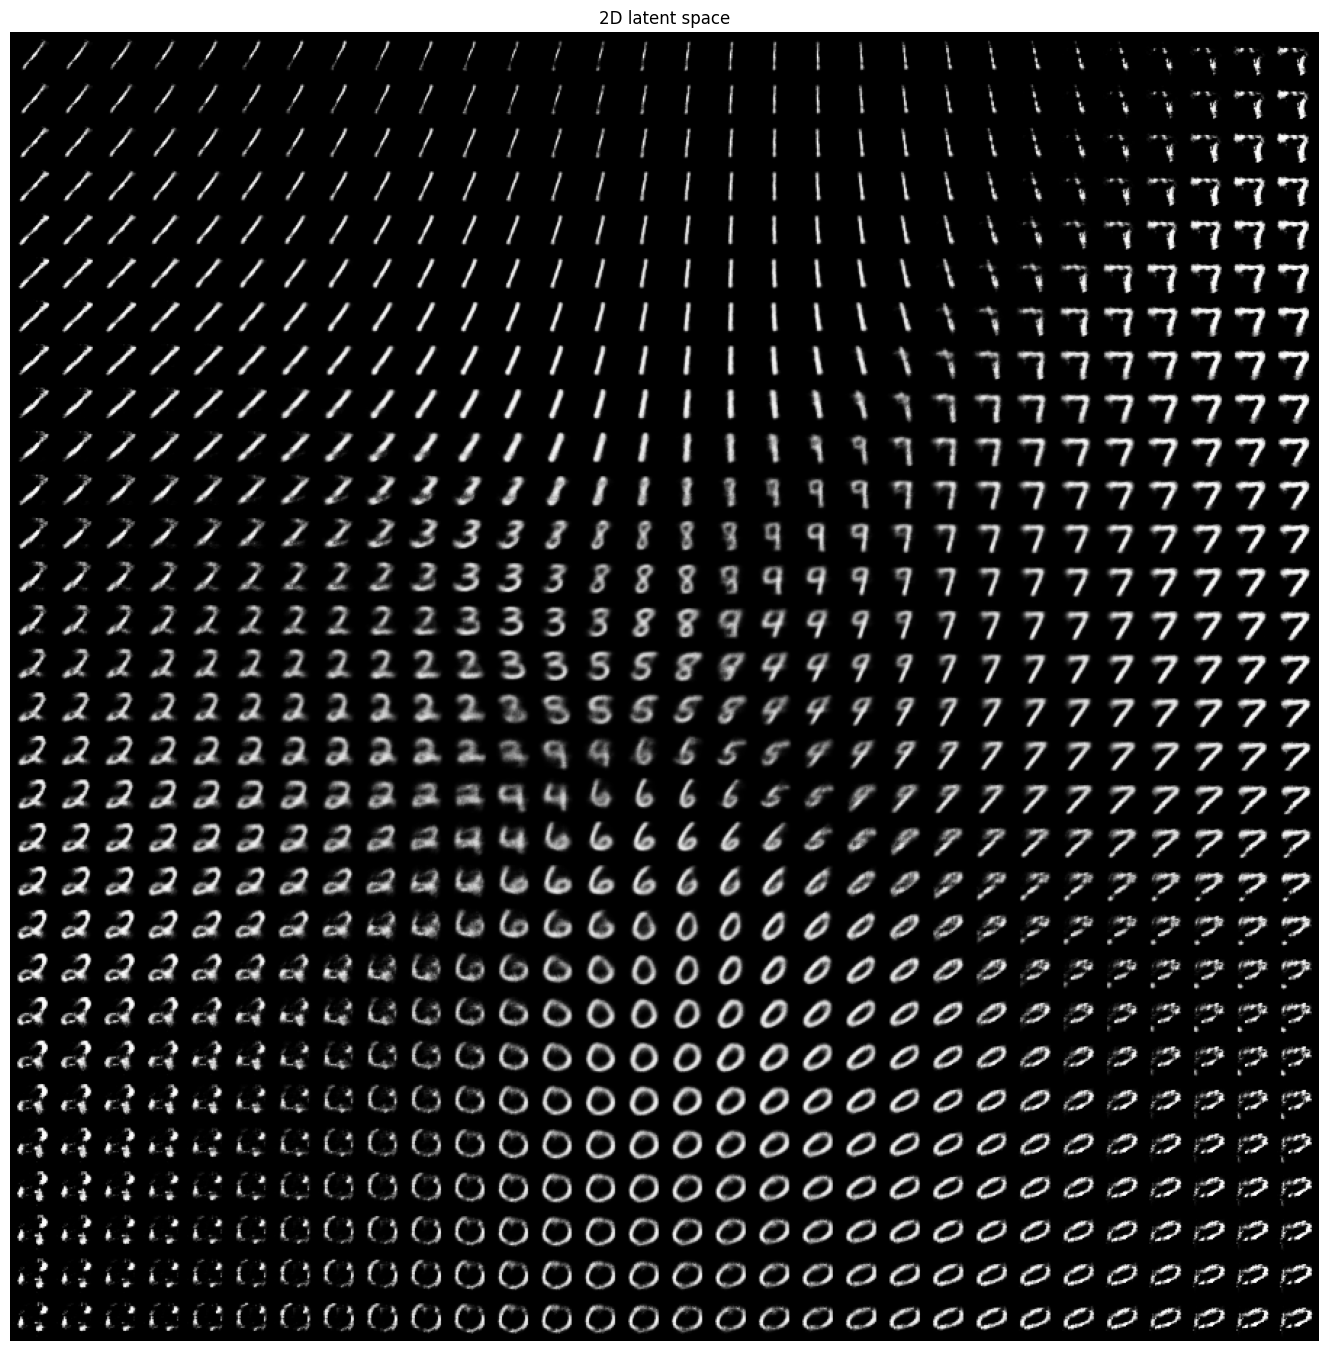

In [36]:
#@title Playground: 2D linear interpolation { run: "auto" }

import matplotlib.pyplot as plt

latents_lims = 3.66 #@param {type:"slider", min:0.01, max:4, step:0.05}
num_interpolations = 30 #@param {type:"slider", min:10, max:50, step:2}

# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_interpolation = torch.linspace(-latents_lims, latents_lims, num_interpolations)
    latent_grid = torch.stack(
        (
            latent_interpolation.repeat(num_interpolations, 1),
            latent_interpolation[:, None].repeat(1, num_interpolations)
        ), dim=-1).view(-1, 2)

    # reconstruct images from the latent vectors
    latent_grid = latent_grid.to(device)
    image_recon = vae.decoder(latent_grid)
    image_recon = image_recon.cpu()

    # Matplolib plot, much faster for static images
    plt.figure(figsize = (17, 17))
    plt.imshow(torchvision.utils.make_grid(image_recon.data[:num_interpolations ** 2],
                                          num_interpolations).permute(1, 2, 0))
    plt.title("2D latent space")
    plt.axis('off')
    plt.show()

    # To use plotly:
    # px.imshow(torchvision.utils.make_grid(image_recon.data[:num_interpolations ** 2],
    #                                       num_interpolations),
    #       title="2D latent space",
    #       color_continuous_scale='grayscale',
    #       color_continuous_midpoint=0.5,
    #       height=1000).show()

...why is it distorted?

We are doing a _linear_ interpolation over a (multivariate) _gaussian_ distribution!

To gain a clear understanding of the entire range of latent features that our model can represent, we should select and interpret points from the latent space based on how likely they are according to the encoder's output. In practice, this involves picking values that are evenly spread out across the range of possibilities defined by the [inverse CDF](http://work.thaslwanter.at/Stats/html/statsDistributions.html#other-important-presentations-of-probability-densities) of a spherical Gaussian distribution. This method ensures that we're exploring the latent space in a way that mirrors the model's expectations about how data is distributed in that space.

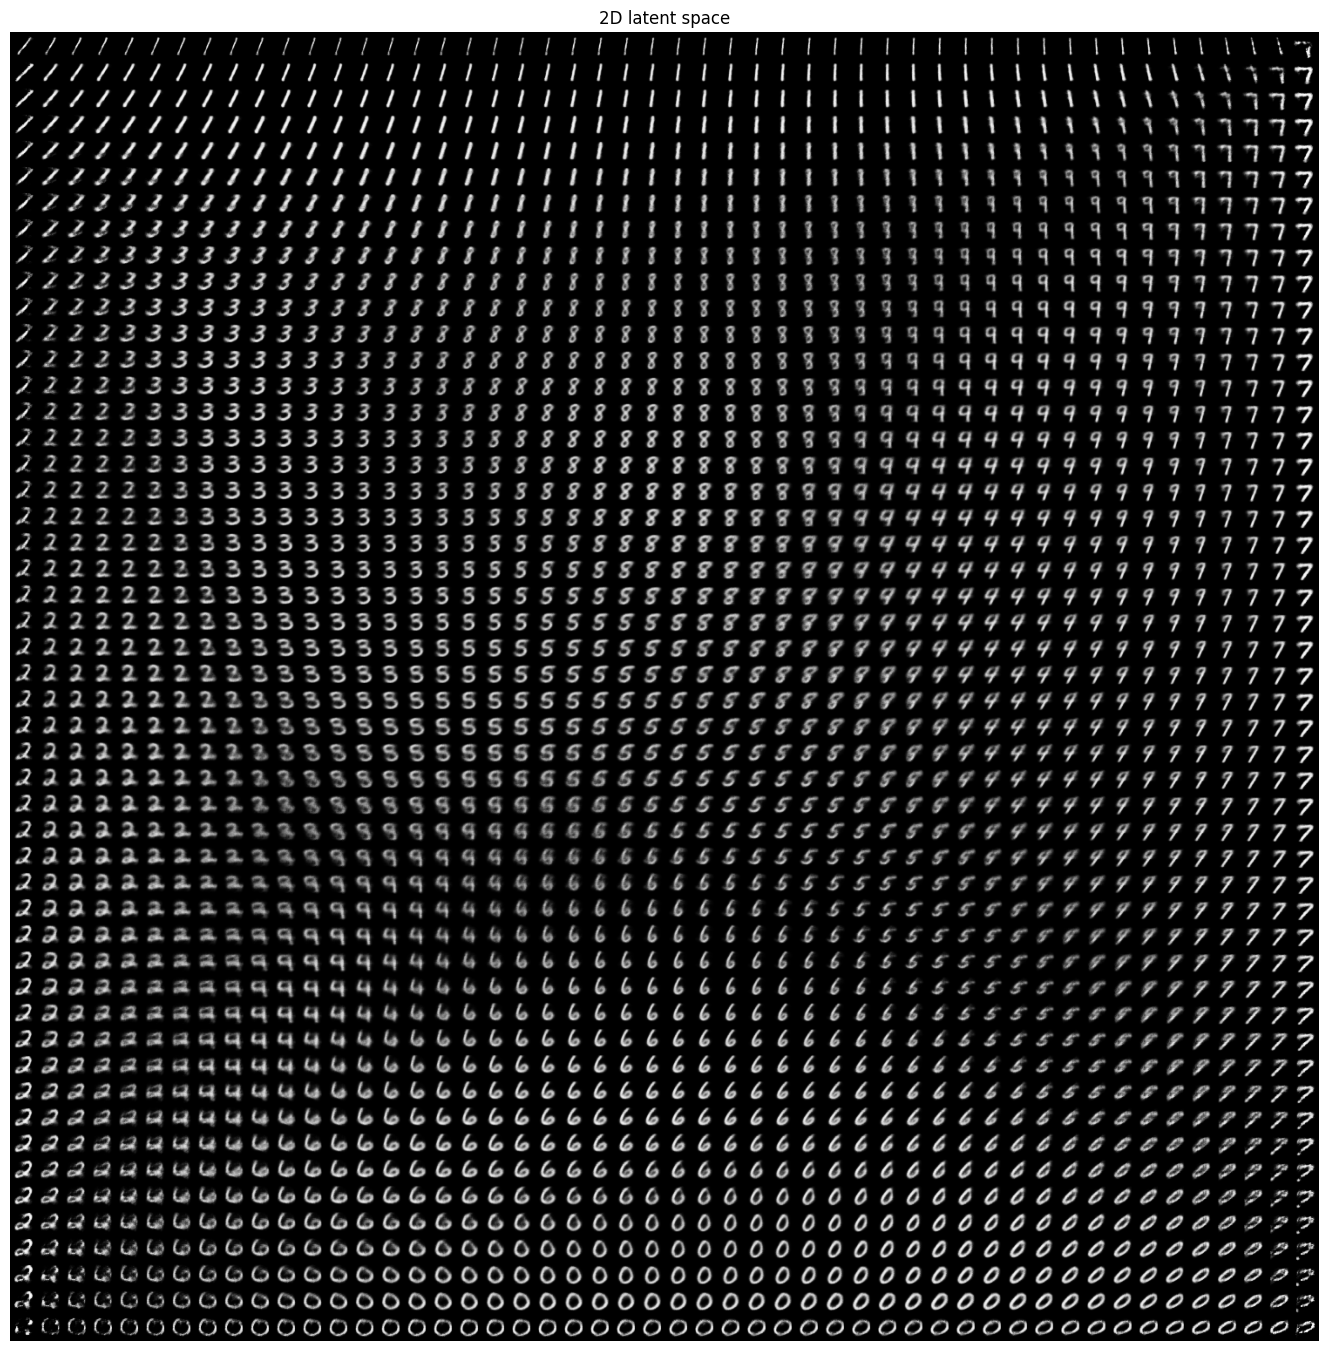

In [37]:
#@title Playground: 2D inverse CDF interpolation { run: "auto" }

import matplotlib.pyplot as plt

num_interpolations = 50 #@param {type:"slider", min:10, max:50, step:2}

from scipy import stats

nd = torch.distributions.Normal(loc=torch.as_tensor([0.]),
                                scale=torch.as_tensor([1.]))

with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_interpolation = torch.linspace(0.001, 0.999, num_interpolations)
    latent_grid = torch.stack(
        (
            latent_interpolation.repeat(num_interpolations, 1),
            latent_interpolation[:, None].repeat(1, num_interpolations)
        ), dim=-1).view(-1, 2)

    latent_grid = nd.icdf(latent_grid)
    # reconstruct images from the latent vectors
    latent_grid = latent_grid.to(device)
    image_recon = vae.decoder(latent_grid)
    image_recon = image_recon.cpu()

    # Matplolib plot, much faster for static images
    plt.figure(figsize = (17, 17))
    plt.imshow(torchvision.utils.make_grid(image_recon.data[:num_interpolations ** 2],
                                          num_interpolations).permute(1, 2, 0))
    plt.title("2D latent space")
    plt.axis('off')
    plt.show()


---

Section inspired from [this](https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb) tutorial and these blog posts:
[post1](https://blog.fastforwardlabs.com/2016/08/22/under-the-hood-of-the-variational-autoencoder-in.html)
[post2](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)
[post3](https://www.jeremyjordan.me/variational-autoencoders/), [post4](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)

### **EXERCISE 1**

> Play with the `variational_beta` hyperparameter to give more or less importance to the KL divergence and see how the latent space and performance change!

### **EXERCISE 2**
> At the beginning of this course, in [notebook 3](https://colab.research.google.com/github/erodola/DLAI-s2-2024/blob/main/labs/03_Linear_models_and_Pytorch_Datasets.ipynb#scrollTo=JiCv7axFUEel), we asked you to create the dataset and data loader for a system that learns how to recover corrupted images.
>
> Here's what we said:
> > You want to create a neural network that is able to learn how to recover corrupted images from the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. That is, given as input a corrupted image, the model outputs a corresponding uncorrupted version.
> >
> > You are free to choose the type of corruption to apply. Possible examples are: random noise, random black patches, random crop, random reflections, all the previous together.
> >
> > 1) Think about the data pipeline this model would require. What should the dataset return?
> >
> > 2) Create the `Dataset` and `DataLoader` to implement it.
> >
> > 3) Plot the images in a **batch** to ensure you are doing everything right.
> >
> > *hint*: you may use [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html)
>
> It's now the time to actually implement, train and compare a standard AE and a VAE that try to recover the original image that you corrupted, using the `Dataset` you previously implemented.
>
> ---
>
> *Can you use the `Dataset` you previously implemented as-is? If yes, good job! If no, ponder what you had to change and the next time you have to implement a `Dataset` try to make use of these insights.*

